## Deutsch - Josza Algorithm 

This notebook implements the Deutsch-Josza algorithm, a quantum algorithm that checks whether a function $f$ that takes an $m$-bit input is balanced or constant, using $m+1$ qubits. This is a generalization of the Deutsch algorithm that takes a one bit input to $f$. Historically, the Deutsch algorithm is the first algorithm that demonstrates a (quantum) query complexity advantage over its classical counterpart. 

### Let's fist consider the simpler case: Deutsch algorithm (one bit input)
We have the function $f$ given as a black box (we do not know the exact function definition, but we are able to evaluate it, such that given an input $x$ we can retrieve $f(x)$), that takes as a input an $m$-bit sequence and a 2-dimensional output space:
$$
    f: \{ 0,1\}^m \rightarrow \{ 0,1\}.
$$

With regard to query complexity, the quantum algorithm needs only one evaluation to check if the function $f$ is balanced or constant, whereas a classical algorithm has the worst case query complexity of $2^{m-1} +1 $ (note that for a binary $m$-bit string we have $2^m$ possible input strings), which is an exponential advantage. 

In [9]:
#install needed packages
!pip install qiskit --upgrade 
!pip install matplotlib

import matplotlib
from qiskit import QuantumCircuit, transpile
#from qiskit.circuit.library import GroverOperator, MCMTGate, ZGate, MCMT, CXGate
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator

## 1. Define the Oracle implementation for our constant (0 or 1 as example) and balanced function

We prepare the quantum circuits in order to fulfill the (reversible) transformation: $| x \rangle | y \rangle \rightarrow | x \rangle | f(x) \oplus y \rangle$ for a constant or balanced function $f$ with $x$ being the $m$-bit input and the output being added to the $(m+1)th$ qubit.

In [10]:
def constant_0_oracle(m):
    """Create a constant 0 oracle for Grover's algorithm."""
    qc = QuantumCircuit(m+1)
    return qc

def constant_1_oracle(m):
    """Create a constant 1 oracle for Grover's algorithm."""
    qc = QuantumCircuit(m+1)
    qc.x(m)
    return qc

def balanced_oracle(m):
    """Create a balanced oracle for Grover's algorithm."""
    qc = QuantumCircuit(m+1)
    for i in range(m // 2):
        qc.x(i)
    # Apply Z gate to the first half of the qubits
    for i in range(m):
        qc.cx(i, m)
    for i in range(m // 2):
        qc.x(i)
    return qc

In [11]:
# let's visualize the quantum circuit for the balanced oracle
qc = balanced_oracle(m=5)
qc.draw()

┌───┐     ┌───┐               
q_0: ┤ X ├──■──┤ X ├───────────────
     ├───┤  │  └───┘┌───┐          
q_1: ┤ X ├──┼────■──┤ X ├──────────
     └───┘  │    │  └───┘          
q_2: ───────┼────┼────■────────────
            │    │    │            
q_3: ───────┼────┼────┼────■───────
            │    │    │    │       
q_4: ───────┼────┼────┼────┼────■──
          ┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐
q_5: ─────┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├
          └───┘└───┘└───┘└───┘└───┘

In [12]:
# Define the Parameters and function type (balanced or constant)
m = 5 # number of bits of the function f -> 2^m possible inputs -> (m+1) qubits needed
oracle = constant_1_oracle # choose oracle type: constant_0_oracle, constant_1_oracle or balanced_oracle

## 2. Prepare the Quantum Circuit for the Deutsch-Josza algorithm

First, we prepare the initial state $ |0\rangle^{m-1} |1 \rangle$ and then apply Hadamard gates $H^{\otimes(m+1)}$, following that, the respective oracle is applied and next, we apply $H^{m} \otimes \mathbb{I}$. Then we measure the first $m$ qubits and conclue wheter the function imlemented via the oracle was balanced or constant by evaluating the measurement outcome. 

In [13]:
# define the quantum circuit of the Deutsch Josza algorithm
qc = QuantumCircuit(m + 1, m)
# initialize the last qubit in state |1> and first m qubits in state |0>
qc.x(m)  # Set the last qubit to |1>

# apply Hadamard gates to the first m qubits
for i in range(m):
    qc.h(i)
qc.h(m)  # apply Hadamard gate to the last qubit
qc.barrier()
# apply the oracle
qc_oracle = oracle(m)
qc_oracle.to_gate(label=' Oracle')
qc.append(qc_oracle, range(m+1))
qc.barrier()
# apply Hadamard gates to the first m qubits again
for i in range(m):
    qc.h(i)
qc.barrier()
# measure the first m qubits
qc.measure(range(m), range(m))
# visualize the circuit
qc.draw()


┌───┐      ░ ┌──────────────┐ ░ ┌───┐ ░ ┌─┐            
q_0: ┤ H ├──────░─┤0             ├─░─┤ H ├─░─┤M├────────────
     ├───┤      ░ │              │ ░ ├───┤ ░ └╥┘┌─┐         
q_1: ┤ H ├──────░─┤1             ├─░─┤ H ├─░──╫─┤M├─────────
     ├───┤      ░ │              │ ░ ├───┤ ░  ║ └╥┘┌─┐      
q_2: ┤ H ├──────░─┤2             ├─░─┤ H ├─░──╫──╫─┤M├──────
     ├───┤      ░ │  circuit-181 │ ░ ├───┤ ░  ║  ║ └╥┘┌─┐   
q_3: ┤ H ├──────░─┤3             ├─░─┤ H ├─░──╫──╫──╫─┤M├───
     ├───┤      ░ │              │ ░ ├───┤ ░  ║  ║  ║ └╥┘┌─┐
q_4: ┤ H ├──────░─┤4             ├─░─┤ H ├─░──╫──╫──╫──╫─┤M├
     ├───┤┌───┐ ░ │              │ ░ └───┘ ░  ║  ║  ║  ║ └╥┘
q_5: ┤ X ├┤ H ├─░─┤5             ├─░───────░──╫──╫──╫──╫──╫─
     └───┘└───┘ ░ └──────────────┘ ░       ░  ║  ║  ║  ║  ║ 
c: 5/═════════════════════════════════════════╩══╩══╩══╩══╩═
                                              0  1  2  3  4

## 3. Simulate the quantum circuit and evaluate the simulation results

Thereby, we know that if $|x\rangle $ is $|0\rangle$, then $f$ is constant and balanced otherwise. 

In [14]:
# define number of shots and backend for simulation 
no_shots =  1e5
backend = AerSimulator()
t_qc = transpile(qc, backend)
result = backend.run(t_qc, shots=no_shots).result()
counts = result.get_counts()


Visualize the simulation results:

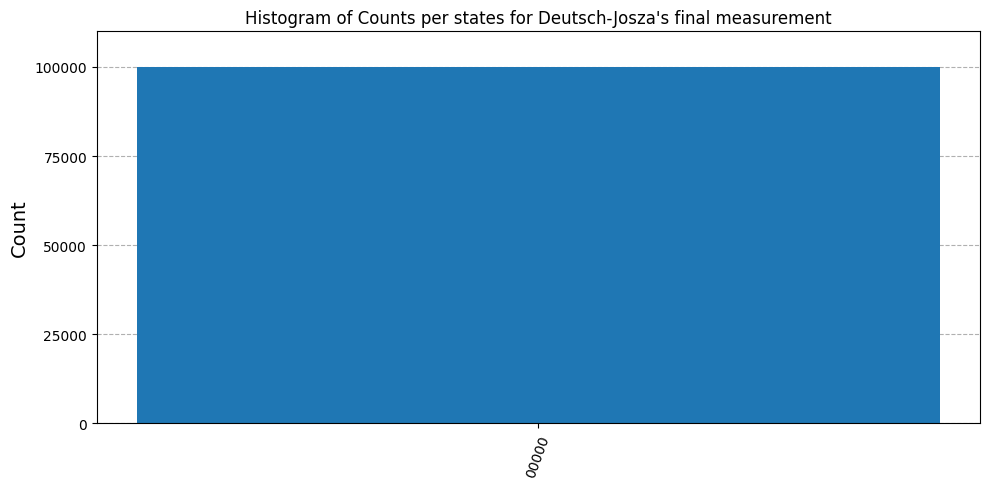

In [15]:
# visualize the counts: measure all-one string for balanced function and all-zero string for constant function
plot_histogram(counts, title='Histogram of Counts per states for Deutsch-Josza\'s final measurement', figsize=(10, 5), bar_labels=False)